# Train feedback estimators using Logistic and Linear Regression

This script trains the following feedback estimators on the ACCORD_BPClass_v2.csv dataset

* CVDRiskEstr: logistic regression, obtain accuracy arounnd 0.88
* SBPEstr: linear regression, poor fitting, R^2 = 0.03
* A1CEstr: linear regression, poor fitting, R^2 = 0.09

In [72]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense
import tensorflow as tf
import pickle
import numpy as np

In [97]:
# DATA = '../data/ACCORD_BPClass_v2_merged_Contextual.csv' # _merged means sbp_discrete levels are merged

# DATA = '../data/ACCORD_BPClass_v2_merged_Contextual_-1NotAvg.csv' # _contextual means we added baseline_BMI_discrete, but we are not using it
                                                                  # -1NotAvg means we are not using the average of adjacent two records, but use -1 to represent the missing value

DATA= '../data/ACCORD_BPClass_v2_merged_Contextual.csv'

context_fea = ['baseline_age', 'female', 'race_whiteother', #'race_black', 
                # 'edu_baseline',
                'edu_baseline_1',
                'edu_baseline_2',
                'edu_baseline_3',
                'cvd_hx_baseline', 
                'baseline_BMI', 
                # 'baseline_BMI_discrete',
                # 'cigarett_baseline',
                'cigarett_baseline_1',
                ]

## Preprocess

In [15]:
# discretize the baseline_BMI

fn = DATA
df = pd.read_csv(fn)

baseline_BMI_discrete = []
for i in range(df.shape[0]):
    row = df.iloc[i]
    BMI = row['baseline_BMI']      

    if BMI < 18.5:
        baseline_BMI_discrete.append(0)
    elif BMI < 25:
        baseline_BMI_discrete.append(1)
    elif BMI < 30:
        baseline_BMI_discrete.append(2)
    else:
        baseline_BMI_discrete.append(3)

df['baseline_BMI_discrete'] = baseline_BMI_discrete

# save to csv
# fn_out = fn.replace('.csv', '_contextual.csv')
fn_out = fn
df.to_csv(fn_out, index=False)

In [58]:
# catrgorize the edu_baseline into 3 columns 

df = pd.read_csv(DATA)

edu1=[]
edu2=[]
edu3=[]
for i in range(df.shape[0]):
    row = df.iloc[i]
    edu = row['edu_baseline']      

    if edu == 1:
        edu1.append(1)
        edu2.append(0)
        edu3.append(0)
    elif edu == 2:
        edu1.append(0)
        edu2.append(1)
        edu3.append(0)
    elif edu == 3:
        edu1.append(0)
        edu2.append(0)
        edu3.append(1)
    elif edu == 4:
        edu1.append(0)
        edu2.append(0)
        edu3.append(0)
    else:
        print('error')
        exit()

df['edu_baseline_1'] = edu1
df['edu_baseline_2'] = edu2
df['edu_baseline_3'] = edu3

# overwrite to csv
df.to_csv(DATA, index=False)

In [59]:
# convert cigarett_baseline into 1 column with 0/1, 1  = 1, 2 = 0

df = pd.read_csv(DATA)
cig1 = []
for i in range(df.shape[0]):
    row = df.iloc[i]
    cig = row['cigarett_baseline']
    if cig == 1:
        cig1.append(1)
    elif cig == 2:
        cig1.append(0)
    else:
        print('error')
        exit()

df['cigarett_baseline_1'] = cig1

# overwrite to csv
df.to_csv(DATA, index=False)

## CVDRisk

In [93]:
def train_CVDRisk_estimator(fn, flag):

    # flag = 'BP' or 'BG' or 'BPBG'
    
    # get the features and labels
    df = pd.read_csv(fn)
    print(df.shape)
    # print(df.info())
    
    if flag == 'BP':
        # state_cols = ['sbp_discrete_merged', 'BMI_discrete'] # state vector
        # state_cols = ['sbp_discrete_merged'] # state vector
        medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB'] # pick top 4 most frequently used BP med classes
                        
    elif flag == 'BG':
        medclass_cols = ['BMI', 'sbp', 'hba1c', 'TC', 'hdl', 
                        'bgclass_none', ]
    elif flag == 'BPBG':
        medclass_cols = ['BMI', 'sbp', 'hba1c', 'TC', 'hdl', 
                        'bpclass_none', 'Diur', 'ACE', 'Beta-blocker', 'CCB', 
                        'ARB', 'Alpha-Beta-blocker', 'Alpha-blocker', 'Sympath', 'Vasod',
                        'bgclass_none', ]
    else:
        print('Error: flag must be BP, BG or BPBG')
        exit()

    fea_cols = context_fea + state_cols + medclass_cols

    print('fea_cols = ', fea_cols)
    # drop rows with -1 value in any of the features
    for fea in fea_cols:
        df = df[df[fea] != -1]
    print(df.shape)

    X = df[fea_cols].values 
    y = df['CVDRisk_feedback_binary'].values # here we use 0.2 as the threshold to make the binarized class balance, as only 3% data has CVDRisk_feedback >= 0.5

    # print('X.shape = ', X.shape)
    # print('y.shape = ', y.shape)
    
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # standardize the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a logistic regression model to predict the risk of CVD
    lr = LogisticRegression(max_iter=400).fit(X_train, y_train)
    probs = lr.predict_proba(X_test)[:,1]
    # print('probs = ', probs)
    threshold = 0.2
    y_pred = (probs >= threshold).astype(int)
    # print('y_pred = ', y_pred)
    # print('y_test = ', y_test)

    # get the accuracy
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_test, y_pred)
    print('test acc = ', acc)

    y_test_numeric = df['CVDRisk_feedback'].values
    # get the MSE between y_text_numeric and probs
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test_numeric, probs)
    print('test mse = ', mse)

    # train_score = lr.score(X_train, y_train)
    # test_score =  lr.score(X_test, y_test)
    # print('train_score = ', train_score)
    # print('test_score = ', test_score)
    """

    # retrain the model on the whole dataset
    from sklearn.preprocessing import StandardScaler
    scaler_all = StandardScaler()
    X = scaler_all.fit_transform(X)
    estimator_all = LogisticRegression(max_iter=400).fit(X, y)
    probs = estimator_all.predict_proba(X)[:,1]
    # print('probs = ', probs)
    threshold = 0.2
    y_pred = (probs >= threshold).astype(int)
    # print('y_pred = ', y_pred)
    # print('y_test = ', y_test)

    # get the accuracy
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y, y_pred)
    print('acc = ', acc)

    y_numeric = df['CVDRisk_feedback'].values
    # get the MSE, MAE, RMSE, r2
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(y_numeric, probs)
    mae = mean_absolute_error(y_numeric, probs)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_numeric, probs)
    print('MSE = ', mse)
    print('MAE = ', mae)
    print('RMSE = ', rmse)
    print('R2 = ', r2)

    return (estimator_all, scaler_all, fea_cols)

CVDRisk_estimator_BP, CVDRisk_scaler_BP, CVDRisk_fea_BP = train_CVDRisk_estimator(DATA, 'BP')

(176880, 83)
fea_cols =  ['baseline_age', 'female', 'race_whiteother', 'edu_baseline_1', 'edu_baseline_2', 'edu_baseline_3', 'cvd_hx_baseline', 'baseline_BMI', 'cigarett_baseline_1', 'sbp_discrete_merged_1', 'sbp_discrete_merged_2', 'Diur', 'ACE', 'Beta-blocker', 'CCB']
(176880, 83)
acc =  0.8267356399819087
MSE =  0.16421437144981035
MAE =  0.3157182785845805
RMSE =  0.4052337244724461
R2 =  -8.511650264093788


If useing only complete entries

(176880, 81)
fea_cols =  ['baseline_age', 'female', 'race_whiteother', 'edu_baseline_1', 'edu_baseline_2', 'edu_baseline_3', 'cvd_hx_baseline', 'cigarett_baseline1', 'sbp_discrete_merged', 'Diur', 'ACE', 'Beta-blocker', 'CCB']
acc =  0.8265264586160108
MSE =  0.16398880651848943
MAE =  0.31561720888219336
RMSE =  0.40495531422428505
R2 =  -8.49858505719608

In [106]:
# train a linear regression model for CVD risk
def train_CVDRisk_estimator_linear(fn):
    # get the features and labels
    df = pd.read_csv(fn)
    print(df.shape)
    # print(df.info())
    # stop

    medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB'] # pick top 4 most frequently used BP med classes

    state_cols = ['sbp_discrete_merged'] # state vector
    # state_cols = ['sbp_discrete_merged_1', 'sbp_discrete_merged_2'] # state vector
    fea_cols = context_fea + state_cols + medclass_cols
    print('fea_cols = ', fea_cols)
 
    X = df[fea_cols].values 
    y = df['CVDRisk_feedback'].values

    # get rows with y = 0
    # dfy0 = df[df['CVDRisk_feedback'] == 0]
    # print('dfy0.shape = ', dfy0.shape)
    # print('dfy0.head() = ', dfy0.head())

    y_true  = y

    # use  -log(1/y-1) to transform the y to a linear scale
    # y = -np.log(1/y-1) 
    y = -np.log((1-y)/y) 

    # save the X and y to a numpy file
    np.save('output/X.npy', X)
    np.save('output/y_true.npy', y_true)
    
     

    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Train a linear regression model to predict the risk of CVD
    lr = LinearRegression().fit(X_train, y_train)
    train_score = lr.score(X_train, y_train)
    test_score =  lr.score(X_test, y_test)
    print('train_score = ', train_score)
    print('test_score = ', test_score)

    # retrain the model on the whole dataset
    estimator_all = LinearRegression().fit(X, y)
    train_score_all = estimator_all.score(X, y)
    print('train_score using all data = ', train_score_all)

    # use RMSE as the evaluation metric
    y_pred = estimator_all.predict(X)
    y_pred_transformed = 1/(1+np.exp(-y_pred))
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_true, y_pred_transformed)
    rmse = np.sqrt(mse)
    print('RMSE = ', rmse)

    # print the coefficients
    print('coef = ', estimator_all.coef_)
    print('intercept = ', estimator_all.intercept_)

    stop

    return estimator_all        

CVDRisk_estimator_BP = train_CVDRisk_estimator_linear(DATA)

# save the estimator model to a file
import pickle
with open('output/CVDRisk_estimator_BP.pkl', 'wb') as f:
    pickle.dump(CVDRisk_estimator_BP, f)

(176880, 83)
fea_cols =  ['baseline_age', 'female', 'race_whiteother', 'edu_baseline_1', 'edu_baseline_2', 'edu_baseline_3', 'cvd_hx_baseline', 'baseline_BMI', 'cigarett_baseline_1', 'sbp_discrete_merged', 'Diur', 'ACE', 'Beta-blocker', 'CCB']
X.shape =  (176880, 14)
y.shape =  (176880,)
train_score =  0.7913080876677394
test_score =  0.7941048066010319
train_score using all data =  0.7918751124374861
RMSE =  0.06569298654488637
coef =  [ 0.08647672 -0.71599168 -0.33732405  0.02057186  0.03697464  0.0296318
  0.05699702  0.00443684  0.71938144  0.29171093 -0.01786874 -0.02156886
  0.02849388 -0.01090756]
intercept =  -6.768294370801318


NameError: name 'stop' is not defined

## SBP

In [109]:
# train a linear regression model for SBP feedback
def train_SBP_estimator(fn):
    # get the features and labels
    df = pd.read_csv(fn)
    print(df.shape)

    medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB'] # pick top 4 most frequently used BP med classes

    # state_cols = ['BMI_discrete']
    # state_cols = ['BMI']
    # state_cols = ['BMI', 'hba1c', 'TC', 'hdl']
    # state_cols = ['hba1c', 'TC', 'hdl']
    state_cols = []
    
    fea_cols = context_fea + state_cols + medclass_cols
    # fea_cols = context_fea + medclass_cols
    # fea_cols = all_fea_cols # try to predict SBP from all features
    # fea_cols = ['BMI'] # try to predict SBP from BMI only
    print('fea_cols = ', fea_cols)

    # drop rows with -1 value in any of the features
    # for fea in fea_cols:
    #     df = df[df[fea] != -1]    

    # only keep rows with 'Visit' = 'F01'
    # df = df[df['Visit'] == 'F01']

    X = df[fea_cols].values 
    y = df['sbp_feedback'].values

    # np.save('output/X_sbp.npy', X)
    # np.save('output/y_sbp.npy', y)

    # check for p values
    # import statsmodels.api as sm
    # X = sm.add_constant(X)
    # model = sm.OLS(y, X).fit()
    # print(model.summary())

    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # use Lasso to fit the model
    # from sklearn.linear_model import Lasso
    # estimator = Lasso(alpha=1).fit(X_train, y_train)

    # use OLS to fit the model
    # from sklearn.linear_model import LinearRegression
    # estimator = LinearRegression().fit(X_train, y_train)

    # train_score = estimator.score(X_train, y_train)
    # test_score =  estimator.score(X_test, y_test)
    # print('train_score = ', train_score)
    # print('test_score = ', test_score)

    # # compute the RMSE score on the test set
    # y_pred = estimator.predict(X_test)
    # from sklearn.metrics import mean_squared_error
    # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print('Test RMSE = ', rmse)


    # # Train a linear regression model to predict the risk of CVD
    # lr = LinearRegression().fit(X_train, y_train)
    # train_score = lr.score(X_train, y_train)
    # test_score =  lr.score(X_test, y_test)
    # print('train_score = ', train_score)
    # print('test_score = ', test_score)

    # retrain the model on the whole dataset
    from sklearn.linear_model import Lasso, Ridge
    # estimator_all = Lasso(alpha=1).fit(X, y)
    # estimator_all = Ridge(alpha=20).fit(X, y)
    estimator_all = LinearRegression().fit(X, y)

    train_score_all = estimator_all.score(X, y)
    print('R2 score = ', train_score_all)
    
    # compute the RMSE score 
    y_pred = estimator_all.predict(X)
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print('RMSE = ', rmse)    

    return estimator_all        
    

SBP_feedback_estimator = train_SBP_estimator(DATA)

stop
# save the estimator model to a file
import pickle
with open('output/SBP_feedback_estimator.pkl', 'wb') as f:
    pickle.dump(SBP_feedback_estimator, f)

(176880, 83)
fea_cols =  ['baseline_age', 'female', 'race_whiteother', 'edu_baseline_1', 'edu_baseline_2', 'edu_baseline_3', 'cvd_hx_baseline', 'baseline_BMI', 'cigarett_baseline_1', 'Diur', 'ACE', 'Beta-blocker', 'CCB']
X.shape =  (176880, 13)
y.shape =  (176880,)
R2 score =  0.03377424467190182
RMSE =  14.85657452468115


NameError: name 'stop' is not defined

In [36]:
# use these features: hr	hba1c	TC	trig	vldl	ldl	hdl	fpg	alt	cpk	potassium	screat	gfr	ualb	ucreat	uacr	edu_baseline	yrsdiab_baseline	yrstens_baseline	cigarett_baseline  BMI	female	baseline_age	race_whiteother cvd_hx_baseline	 Diur	ACE	Beta-blocker	CCB	ARB	Alpha-Beta-blocker	Alpha-blocker	Sympath	Vasod
all_fea_cols = ['hr', 'hba1c', 'TC', 'trig', 'vldl', 'ldl',	'hdl',	'fpg',	'alt',	'cpk',	'potassium',	'screat',	'gfr',	'ualb',	'ucreat',
        	'uacr',	'edu_baseline',	'yrsdiab_baseline',	'yrstens_baseline',	'cigarett_baseline',  'BMI',	'female',	'baseline_age',	'race_whiteother',
            'cvd_hx_baseline',	'Diur',	'ACE',	'Beta-blocker',	'CCB',	'ARB',	'Alpha-Beta-blocker',	'Alpha-blocker',	'Sympath',	'Vasod'] 

# calculate feature correlation with SBP feedback

## A1C

In [48]:
# train a linear regression model for A1C feedback
def train_A1C_estimator(fn):
    # get the features and labels
    df = pd.read_csv(fn)
    state_cols = ['sbp_discrete'] # state vector
    medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB'] # pick top 4 most frequently used BP med classes

    fea_cols = context_fea + state_cols + medclass_cols
 
    X = df[fea_cols].values 
    y = df['hba1c_feedback'].values

    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Train a linear regression model to predict the risk of CVD
    lr = LinearRegression().fit(X_train, y_train)
    train_score = lr.score(X_train, y_train)
    test_score =  lr.score(X_test, y_test)
    print('train_score = ', train_score)
    print('test_score = ', test_score)

    # retrain the model on the whole dataset
    estimator = LinearRegression().fit(X, y)
    train_score2 = estimator.score(X, y)
    print('train_score using all data = ', train_score2)

    return estimator        

SBP_estimator = train_A1C_estimator(DATA)

X.shape =  (176880, 12)
y.shape =  (176880,)
train_score =  0.06572702164722866
test_score =  0.061136848555230716
train_score using all data =  0.06483805076386895


# Train Estimators using ANN

## ANN model class

In [5]:
# write a class which build a ANN model for SBP feedback, using tensorflow framwork
# from wandb.keras import WandbCallback

class ANN:
    def __init__(self, input_shape, output_shape, hidden_layers, output_activation='linear'):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_layers = hidden_layers        
        
        # Define the model architecture
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Input(shape=input_shape))
        for i in range(len(hidden_layers)):
            # self.model.add(tf.keras.layers.Dense(hidden_layers[i], activation='relu'))
            self.model.add(tf.keras.layers.Dense(hidden_layers[i], activation='linear'))
        self.model.add(tf.keras.layers.Dense(output_shape, activation=output_activation))

        # wandb.init(project="SBP_feedback")
        
    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=16):
        # Compile the model with appropriate loss function and optimizer
        self.model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        # self.model.compile(loss='mean_squared_error', optimizer='adam')
        
        # Train the model
        self.model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)
    
    def evaluate(self, x, y):
        # Evaluate the model on the test set
        return self.model.evaluate(x, y)
        
    def predict(self, x):
        # Use the model to make predictions
        return self.model.predict(x)

## CVDRisk

In [41]:
# train a ANN model for CVDRisk 
def train_CVDRisk_estimator_ANN(fn, flag, train_onwhole=False):
    # flag = 'BP' or 'BG' or 'BPBG'
    
    # get the features and labels
    df = pd.read_csv(fn)

    if flag == 'BP':
        state_cols = ['sbp_discrete_merged'] # state vector

        medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB'] # pick top 4 most frequently used BP med classes

    elif flag == 'BG':
        medclass_cols = ['BMI', 'sbp', 'hba1c', 'TC', 'hdl', 
                        'bgclass_none', ]
    elif flag == 'BPBG':
        medclass_cols = ['BMI', 'sbp', 'hba1c', 'TC', 'hdl', 
                        'bpclass_none', 'Diur', 'ACE', 'Beta-blocker', 'CCB', 
                        'ARB', 'Alpha-Beta-blocker', 'Alpha-blocker', 'Sympath', 'Vasod',
                        'bgclass_none', ]
    else:
        print('Error: flag must be BP, BG or BPBG')
        exit()

    fea_cols = context_fea + state_cols + medclass_cols
    X = df[fea_cols].values 
    y = df['CVDRisk_feedback'].values
    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training and testing sets
    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=100)

    # model = ANN(X.shape[1], 1, [16, 8], 'sigmoid')
    model = ANN(X.shape[1], 1, [16, 8], 'linear')
    if not train_onwhole: # to explore hyperparameters
        model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)
        test_score = model.evaluate(X_test, y_test)
        print('test_score = ', test_score)
        return (None, fea_cols)

    else: # retrain the model on the whole dataset
        model.train(X, y, X, y, epochs=20, batch_size=32)    
        return (model, fea_cols)

# none, CVDRisk_fea = train_CVDRisk_estimator_ANN('../../../Codes/Accord/data/ACCORD_BPClass_v2.csv', 'BP')    
CVDRisk_estimator_ANN_BP, CVDRisk_fea_BP = train_CVDRisk_estimator_ANN(DATA, 'BP', True)

X.shape =  (176906, 12)
y.shape =  (176906,)


2023-04-17 20:52:03.328981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
5529/5529 [==============================] - 10s 2ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/20
5529/5529 [==============================] - 9s 2ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 3/20
5529/5529 [==============================] - 11s 2ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/20
5529/5529 [==============================] - 9s 2ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/20
5529/5529 [==============================] - 11s 2ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/20
5529/5529 [==============================] - 11s 2ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/20
5529/5529 [==============================] - 15s 3ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/20
5529/5529 [==============================] - 1

## SBP

In [28]:
# train SBP estimator using ANN model
def train_SBP_estimator_ANN(fn, train_onwhole=False):
    # get the features and labels
    df = pd.read_csv(fn)

    state_cols = ['BMI']
    medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB']

    fea_cols = context_fea + state_cols + medclass_cols
    X = df[fea_cols].values 
    y = df['sbp_feedback'].values

    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training, validation and testing sets
    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=100)

    # model = ANN(X.shape[1], 1, [16, 8])
    model = ANN(X.shape[1], 1, [8])
    if not train_onwhole: # to explore hyperparameters
        model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=20)
        test_score = model.evaluate(X_test, y_test)
        print('test_score = ', test_score)
        y_test = y_test.reshape(-1, 1)
        y_pred = model.predict(X_test)

    else: # retrain the model on the whole dataset
        model.train(X, y, X, y, epochs=20, batch_size=20)
        y_test = y
        y_pred = model.predict(X)  

    return (model, fea_cols, y_test, y_pred)


SBP_estimator_ANN, SBP_fea, y_test, y_pred = train_SBP_estimator_ANN(DATA)

X.shape =  (176880, 11)
y.shape =  (176880,)
Epoch 1/10
6191/6191 [==============================] - 9s 1ms/step - loss: 714.6582 - mse: 714.6582 - val_loss: 304.9782 - val_mse: 304.9782
Epoch 2/10
6191/6191 [==============================] - 9s 1ms/step - loss: 297.5575 - mse: 297.5575 - val_loss: 293.3586 - val_mse: 293.3586
Epoch 3/10
6191/6191 [==============================] - 11s 2ms/step - loss: 288.1699 - mse: 288.1699 - val_loss: 281.8122 - val_mse: 281.8122
Epoch 4/10
6191/6191 [==============================] - 14s 2ms/step - loss: 277.6933 - mse: 277.6933 - val_loss: 269.7856 - val_mse: 269.7856
Epoch 5/10
6191/6191 [==============================] - 9s 1ms/step - loss: 266.2431 - mse: 266.2431 - val_loss: 259.3635 - val_mse: 259.3635
Epoch 6/10
6191/6191 [==============================] - 7s 1ms/step - loss: 255.4201 - mse: 255.4201 - val_loss: 247.3244 - val_mse: 247.3244
Epoch 7/10
6191/6191 [==============================] - 8s 1ms/step - loss: 245.4143 - mse: 245.4143 

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176880 entries, 0 to 176879
Data columns (total 77 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MaskID                   176880 non-null  int64  
 1   Visit                    176880 non-null  object 
 2   glycemia                 169214 non-null  float64
 3   bp                       114044 non-null  float64
 4   sbp                      176880 non-null  float64
 5   dbp                      176880 non-null  float64
 6   hr                       176880 non-null  float64
 7   hba1c                    176880 non-null  float64
 8   TC                       176880 non-null  float64
 9   trig                     176880 non-null  float64
 10  vldl                     176880 non-null  float64
 11  ldl                      176880 non-null  float64
 12  hdl                      176880 non-null  float64
 13  fpg                      176880 non-null  float64
 14  alt 

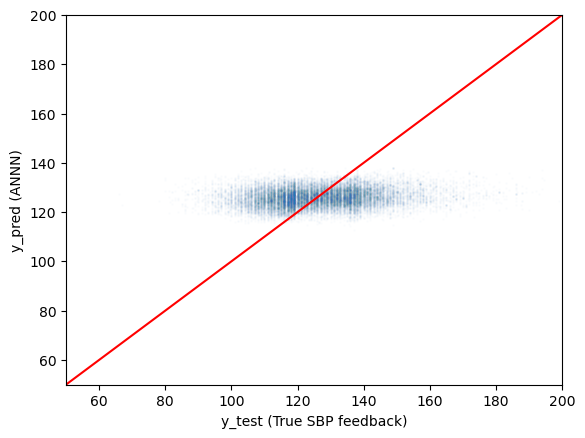

R2: 0.013788917597178041


In [34]:
# plot y_pred vs y_test
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, s=1, alpha=0.01)
plt.plot([0, 200], [0, 200], 'r')
plt.xlim([50,200])
plt.ylim([50,200])
plt.xlabel('y_test (True SBP feedback)')
plt.ylabel('y_pred (ANNN)')
plt.show()

# calculate R2 score
from sklearn.metrics import r2_score
print('R2:', r2_score(y_test, y_pred))

In [21]:
SBP_estimator_ANN, SBP_fea, y_test, y_pred = train_SBP_estimator_ANN(DATA, True)

X.shape =  (176880, 11)
y.shape =  (176880,)
Epoch 1/20
8844/8844 [==============================] - 21s 2ms/step - loss: 423.0682 - mse: 423.0682 - val_loss: 294.6169 - val_mse: 294.6169
Epoch 2/20
8844/8844 [==============================] - 15s 2ms/step - loss: 289.7946 - mse: 289.7946 - val_loss: 282.8262 - val_mse: 282.8262
Epoch 3/20
8844/8844 [==============================] - 17s 2ms/step - loss: 277.9310 - mse: 277.9310 - val_loss: 271.5059 - val_mse: 271.5059
Epoch 4/20
8844/8844 [==============================] - 17s 2ms/step - loss: 265.8736 - mse: 265.8736 - val_loss: 257.9654 - val_mse: 257.9654
Epoch 5/20
8844/8844 [==============================] - 16s 2ms/step - loss: 253.6542 - mse: 253.6542 - val_loss: 247.7036 - val_mse: 247.7036
Epoch 6/20
8844/8844 [==============================] - 22s 2ms/step - loss: 242.3964 - mse: 242.3964 - val_loss: 240.1601 - val_mse: 240.1601
Epoch 7/20
8844/8844 [==============================] - 18s 2ms/step - loss: 233.9283 - mse: 233.

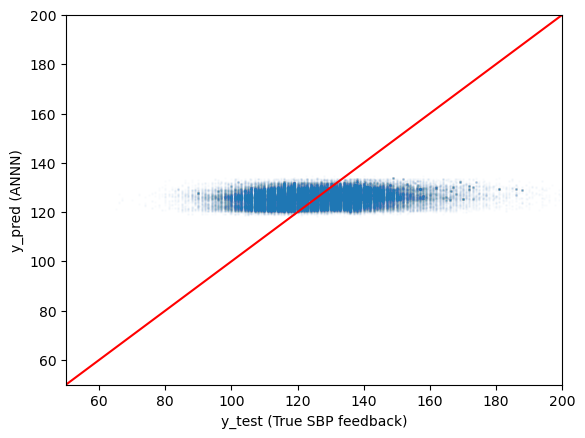

In [27]:
# plot y_pred vs y_test
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, s=1, alpha=0.01)
plt.plot([0, 200], [0, 200], 'r')
plt.xlim([50,200])
plt.ylim([50,200])
plt.xlabel('y_test (True SBP feedback)')
plt.ylabel('y_pred (ANNN)')
plt.show()

In [49]:
# get the model weights layer by layer from SBP_estimator_ANN

def get_model_weights(model):
    weights = []
    for layer in model.model.layers:
        weights.append(layer.get_weights())
    return weights

W = get_model_weights(SBP_estimator_ANN)
print(W)

# sort the weights of the layer 0 by absolute value, and print the top 20 weights, along with their indices
W0 = W[0]
W0 = np.array(W0)
W0 = W0[0]
W0 = np.array(W0)
W0 = np.absolute(W0)
W0 = np.sort(W0)
print(W0[-20:])
print(np.argsort(W0)[-20:])

[[array([[ 1.23055239e+01,  6.28222561e+00, -9.60859108e+00,
        -1.40770590e+00, -1.02785778e+01, -1.35030613e+01,
        -6.78499603e+00, -8.23610878e+00,  4.64829636e+00,
        -1.53135233e+01,  1.61753349e+01,  6.52949905e+00,
        -1.01613274e+01, -7.09677553e+00,  9.91739941e+00,
         1.18261003e+01],
       [ 2.17261429e+01,  1.47915812e+01, -2.23794956e+01,
        -2.19780970e+00, -1.56370401e+01, -2.73054523e+01,
        -1.98372173e+01, -1.08433237e+01,  7.75818014e+00,
        -3.26164932e+01,  3.32807961e+01,  2.94720483e+00,
        -1.59882488e+01, -1.63541813e+01,  2.24738903e+01,
         1.77999916e+01],
       [ 6.85326529e+00,  2.80290842e+00, -3.72410178e+00,
        -3.42627078e-01, -5.66016769e+00, -7.26308155e+00,
        -1.86972368e+00, -5.21857977e+00,  2.36284018e+00,
        -9.51217556e+00,  8.16311264e+00,  3.95363379e+00,
        -4.70252895e+00, -1.99355042e+00,  5.38707829e+00,
         6.39844179e+00],
       [ 1.56875505e+01,  9.3200140

/var/folders/__/mbqb065914l95brxrt7k504w0000gn/T/ipykernel_80292/1113367037.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  W0 = np.array(W0)


## A1C 

In [10]:
# train a ANN model for A1C feedback
def train_A1C_estimator_ANN(fn, train_onwhole=False):
    # get the features and labels
    df = pd.read_csv(fn)

    medclass_cols = ['BMI', 'sbp', 'TC', 'hdl',   
                    'bgclass_none', 'Bingu', 'Thiaz', 'Sulfon', 'Meglit', 
                    'Alpha-gluc']

    fea_cols = context_fea + medclass_cols
    X = df[fea_cols].values 
    y = df['hba1c'].values

    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    
    # Split the data into training, validation and testing sets
    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=100)

    model = ANN(X.shape[1], 1, [16, 8])
    if not train_onwhole: # to explore hyperparameters
        model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)
        test_score = model.evaluate(X_test, y_test)
        print('test_score = ', test_score)
        return (None, fea_cols)
    else:
        model.train(X, y, X, y, epochs=15, batch_size=32)    
        return (model, fea_cols)       

# none, A1C_fea = train_A1C_estimator_ANN('../../../Codes/Accord/data/ACCORD_BGClass_v2.csv')
A1C_estimator_ANN, A1C_fea = train_A1C_estimator_ANN('../../../Codes/Accord/data/ACCORD_BGClass_v2.csv', True)

X.shape =  (290467, 17)
y.shape =  (290467,)
Epoch 1/15
9078/9078 [==============================] - 18s 2ms/step - loss: 323339.7812 - val_loss: 16.1397
Epoch 2/15
9078/9078 [==============================] - 19s 2ms/step - loss: 25794.3047 - val_loss: 920.3678
Epoch 3/15
9078/9078 [==============================] - 17s 2ms/step - loss: 16736.1738 - val_loss: 5715.7778
Epoch 4/15
9078/9078 [==============================] - 20s 2ms/step - loss: 14569.7510 - val_loss: 156323.9062
Epoch 5/15
9078/9078 [==============================] - 25s 3ms/step - loss: 15216.2100 - val_loss: 5436.5928
Epoch 6/15
9078/9078 [==============================] - 22s 2ms/step - loss: 5136.6772 - val_loss: 1187.3887
Epoch 7/15
9078/9078 [==============================] - 23s 3ms/step - loss: 1994.5747 - val_loss: 123.3015
Epoch 8/15
9078/9078 [==============================] - 24s 3ms/step - loss: 5.3624 - val_loss: 1.0676
Epoch 9/15
9078/9078 [==============================] - 21s 2ms/step - loss: 1.0831 -

## Save trained model for RL feedback

In [18]:
estimators = {'CVDRisk-BP': CVDRisk_estimator_ANN_BP, 'SBP': SBP_estimator_ANN, 'A1C': A1C_estimator_ANN}
feature_cols = {'CVDRisk-BP': CVDRisk_fea_BP, 'SBP': SBP_fea, 'A1C': A1C_fea}

# save the estimators and feature columns
with open('estimators.pkl', 'wb') as f:
    pickle.dump(estimators, f)

with open('feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

INFO:tensorflow:Assets written to: ram://ef1c0d68-e16a-48f8-8607-ae7c517c88cc/assets
INFO:tensorflow:Assets written to: ram://9afb876a-7a58-40e2-b0f0-0b64595f98d0/assets
INFO:tensorflow:Assets written to: ram://20326107-bf74-4531-a314-ed37f7657990/assets


## Checking

Plot predictor variable with SBP

fea_cols =  ['baseline_age', 'female', 'race_whiteother', 'edu_baseline', 'cvd_hx_baseline', 'baseline_BMI', 'cigarett_baseline', 'BMI', 'TC', 'hdl', 'Diur', 'ACE', 'Beta-blocker', 'CCB']
14


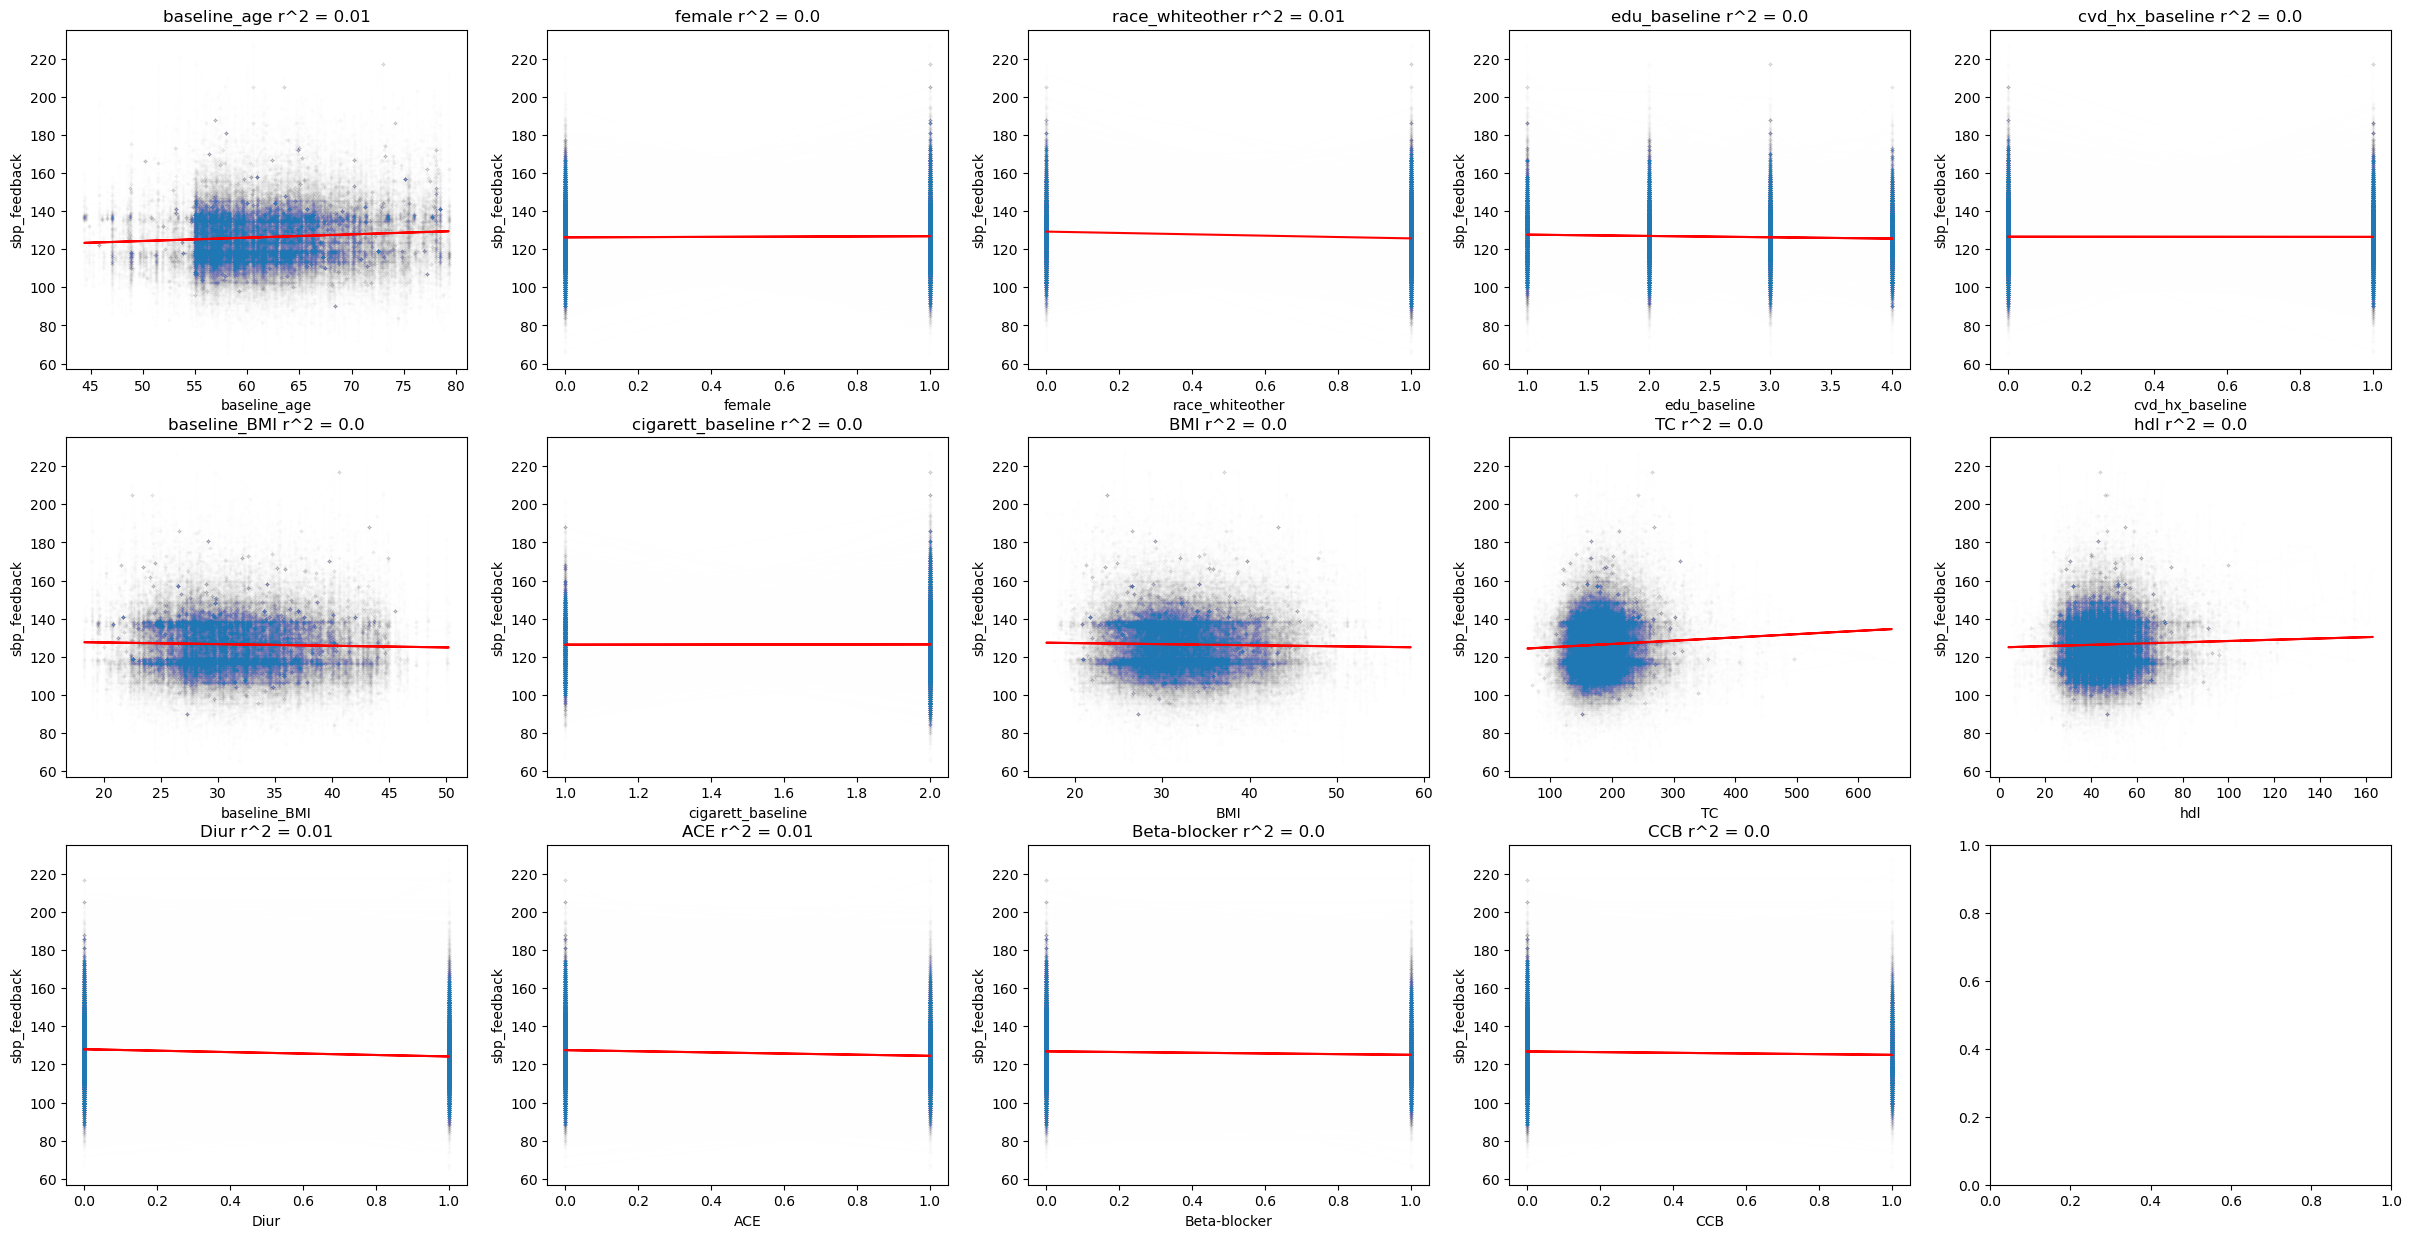

In [63]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



df = pd.read_csv(DATA)
medclass_cols =['Diur', 'ACE', 'Beta-blocker', 'CCB']
state_col = ['BMI','TC','hdl']
fea_cols = context_fea + state_col + medclass_cols
print('fea_cols = ', fea_cols)
X = df[fea_cols].values
# y = df['sbp_feedback'].values
label_col = 'sbp_feedback'
# print(X.shape)
# print(y.shape)

# use 5x3 subplot to plot each of the features scatter plot with the label
n = len(fea_cols)
print(n)
fig, ax = plt.subplots(3, 5, figsize=(30, 15))
for i in range(n):
    row = i // 5
    col = i % 5
    # ax[row][col].scatter(df[fea_cols[i]], df[label_col], alpha=0.005, marker='.', markersize=1)
    ax[row][col].plot(df[fea_cols[i]], df[label_col], alpha=0.005, marker='o', markersize=2)

    # fit a linear regression line
    reg = LinearRegression().fit(df[fea_cols[i]].values.reshape(-1, 1), df[label_col].values.reshape(-1, 1))
    ax[row][col].plot(df[fea_cols[i]], reg.predict(df[fea_cols[i]].values.reshape(-1, 1)), color='red')

    # show the r^2 score
    ax[row][col].set_title(fea_cols[i] + ' r^2 = ' + str(round(reg.score(df[fea_cols[i]].values.reshape(-1, 1), df[label_col].values.reshape(-1, 1)), 2)))

    ax[row][col].set_xlabel(fea_cols[i])
    ax[row][col].set_ylabel(label_col)
plt.show()

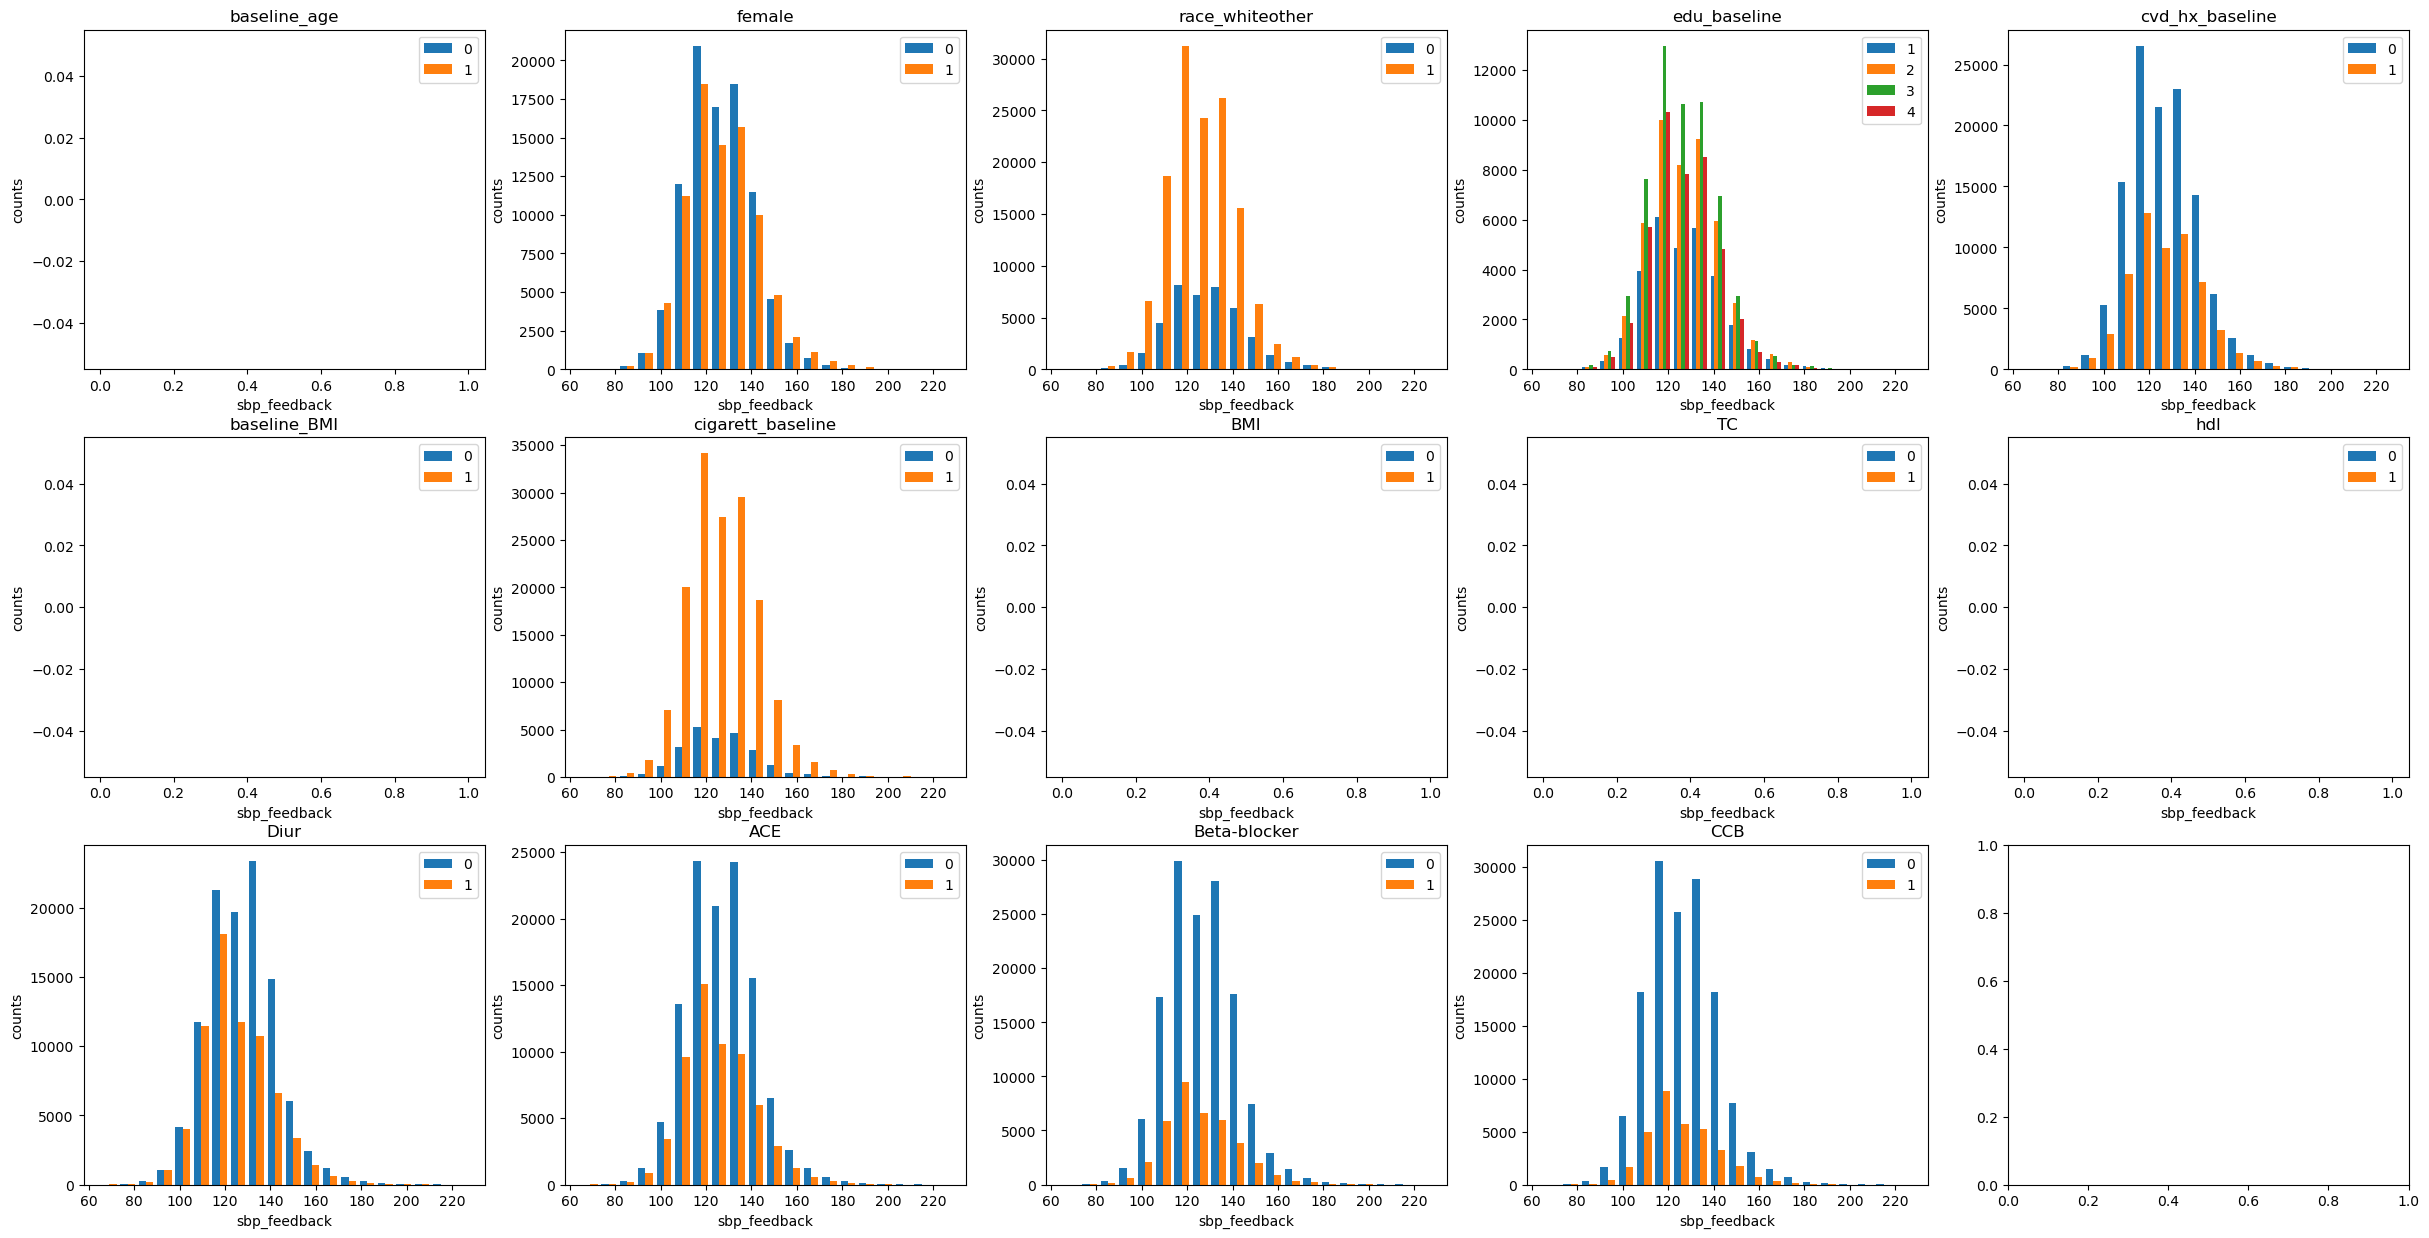

In [68]:
# plot the histogram of the label when the feature is 0 and 1
fig, ax = plt.subplots(3, 5, figsize=(30, 15))
for i in range(n):
    row = i // 5
    col = i % 5
    cat1 = 0
    cat2 = 1
    if fea_cols[i] == 'cigarett_baseline':
        cat1 = 1
        cat2 = 2
    if fea_cols[i] == 'edu_baseline':
        cat1 = 1
        cat2 = 2
        cat3 = 3
        cat4 = 4
        ax[row][col].hist([df[df[fea_cols[i]] == cat1][label_col], df[df[fea_cols[i]] == cat2][label_col], df[df[fea_cols[i]] == cat3][label_col], df[df[fea_cols[i]] == cat4][label_col]], bins=20, label=['1', '2', '3', '4'])
    else:
        ax[row][col].hist([df[df[fea_cols[i]] == cat1][label_col], df[df[fea_cols[i]] == cat2][label_col]], bins=20, label=['0', '1'])
    
    ax[row][col].set_title(fea_cols[i])
    # ax[row][col].set_xlabel(fea_cols[i])
    ax[row][col].set_xlabel(label_col)
    ax[row][col].set_ylabel('counts')
    ax[row][col].legend()

                   baseline_age    female  race_whiteother  edu_baseline  \
baseline_age           1.000000 -0.005608         0.023104     -0.105508   
female                -0.005608  1.000000        -0.118972     -0.118571   
race_whiteother        0.023104 -0.118972         1.000000      0.130997   
edu_baseline          -0.105508 -0.118571         0.130997      1.000000   
cvd_hx_baseline       -0.043711 -0.154536         0.046027     -0.035449   
baseline_BMI          -0.175911  0.154030        -0.025782     -0.011013   
cigarett_baseline      0.138899  0.053104         0.022789      0.018761   
BMI                   -0.207228  0.131374        -0.023092     -0.017284   
TC                    -0.092837  0.156955        -0.067430     -0.014881   
hdl                    0.089579  0.351616        -0.237553     -0.000969   
Diur                   0.021048  0.012951        -0.006191      0.012483   
ACE                   -0.022982 -0.076225         0.015526      0.018451   
Beta-blocker

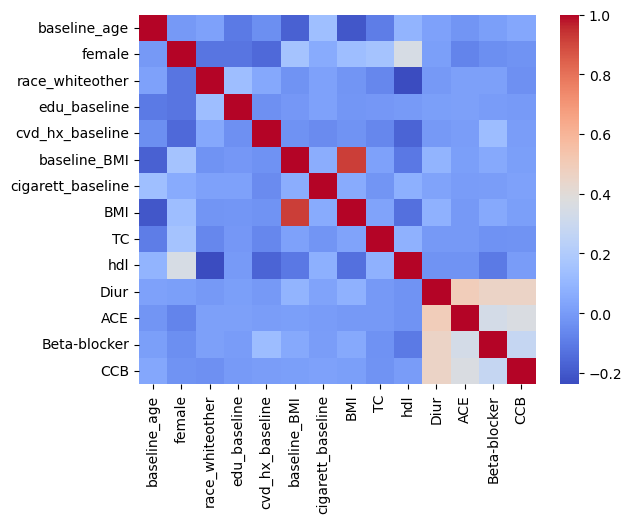

In [74]:
# compute the correlation between each feature in df[fea_cols]
corr = df[fea_cols].corr()
print(corr)

# plot the correlation matrix using seaborn
import seaborn as sns

# change colormap to 'coolwarm'
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm')
plt.show()

In [60]:
# compute the correlation between each feature and the label
corr = df[fea_cols].corrwith(df[label_col])
print(corr)

baseline_age         0.076456
female               0.019537
race_whiteother     -0.099710
edu_baseline        -0.046242
cvd_hx_baseline     -0.002663
baseline_BMI        -0.031441
cigarett_baseline    0.003089
BMI                 -0.022359
TC                   0.049273
hdl                  0.029874
Diur                -0.121634
ACE                 -0.093623
Beta-blocker        -0.049921
CCB                 -0.046096
dtype: float64


In [52]:
print(df['sbp_feedback'].describe())

count    176880.000000
mean        126.476852
std          15.114041
min          65.000000
25%         116.000000
50%         125.500000
75%         136.000000
max         227.000000
Name: sbp_feedback, dtype: float64


In [38]:
# describe the baseline BMI
df = pd.read_csv(DATA)
print(df.shape)
# drop rows with wt_kg_baseline = -1, and ht_cm_baseline = -1
df = df[df['wt_kg_baseline'] != -1]
df = df[df['ht_cm_baseline'] != -1]
print(df.shape)


print(df['baseline_BMI'].describe())
# df.describe()
print(df[df['baseline_BMI'] < 0]['baseline_BMI'])

# find which row has the baseline_BMI = 823000
print(df[df['baseline_BMI'] > 100]['baseline_BMI'])

# save the df to a csv file
fnout = DATA.replace('.csv', '_Contextual.csv')
df.to_csv(fnout, index=False)

(176906, 77)
(176880, 77)
count    176880.000000
mean         31.967916
std           5.520630
min          18.288264
25%          27.856759
50%          31.438328
75%          35.733612
max          50.202878
Name: baseline_BMI, dtype: float64
Series([], Name: baseline_BMI, dtype: float64)
Series([], Name: baseline_BMI, dtype: float64)
